In [1]:
# set width = 95%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Data Exploration

## useful functions

In [3]:
def get_norm_pneu_dir(base_dir):
    return os.path.join(base_dir, 'NORMAL'), os.path.join(base_dir, 'PNEUMONIA')

def get_image_filenames(root_dir):
    files = []
    for file in os.listdir(root_dir):
        if file.endswith('.jpeg'):
            files.append(os.path.join(root_dir, file))
    return files

def split_bacteria_virus(files):
    bacteria_files = []
    virus_files = []
    for file in files:
        if "bacteria" in file:
            bacteria_files.append(file)
        elif "virus" in file:
            virus_files.append(file)
    return bacteria_files, virus_files

def file_to_array(file):
    image = np.asarray(Image.open(file))
    if len(image.shape) == 3: # remove color
        image = np.mean(image, axis=2)
    return image

def load_dataset(norm_files, pneu_bact_files, pneu_virus_files):
    dataset = {'image_file': [], 'is_bact': [], 'is_virus': [], 'is_normal': []}
    for file in norm_files:
        dataset['image_file'].append(file)
        dataset['is_normal'].append(1)
        dataset['is_bact'].append(0)
        dataset['is_virus'].append(0)
    for file in pneu_bact_files:
        dataset['image_file'].append(file)
        dataset['is_normal'].append(0)
        dataset['is_bact'].append(1)
        dataset['is_virus'].append(0)
    for file in pneu_virus_files:
        dataset['image_file'].append(file)
        dataset['is_normal'].append(0)
        dataset['is_bact'].append(0)
        dataset['is_virus'].append(1)
    dataset = pd.DataFrame(dataset)
#     dataset['is_normal'] =  1 - np.amax([dataset['is_bact'], dataset['is_virus']],axis=0)
    return dataset
    
def read_dataset(root_dir):
    # get sub directories
    norm_dir, pneu_dir = get_norm_pneu_dir(root_dir)
    # get image file names
    norm_files = get_image_filenames(norm_dir)
    pneu_files = get_image_filenames(pneu_dir)
    # split viral and bacterial sets
    pneu_bact_files, pneu_virus_files = split_bacteria_virus(pneu_files)
    dataset = load_dataset(norm_files, pneu_bact_files, pneu_virus_files)
    return dataset

def center_crop(image_data):
    if image_data.shape[0] > image_data.shape[1]:
        crop_width = image_data.shape[0] - image_data.shape[1]
        crop_pad = crop_width // 2
        image_data = image_data[crop_pad:crop_pad+image_data.shape[1], :]
    else:
        crop_width = image_data.shape[1] - image_data.shape[0]
        crop_pad = crop_width // 2
        image_data = image_data[:,crop_pad:crop_pad+image_data.shape[0]]
    return image_data
        

def get_image_stats(file, center_crop_bool=False):
    image_data = file_to_array(file)
    if center_crop_bool:
        image_data = center_crop(image_data)
    stats = {}
    stats['width'] = image_data.shape[0]
    stats['height'] = image_data.shape[1]
    stats['aspect_ratio'] = stats['width'] / stats['height']
    stats['mean'] = image_data.mean()
    stats['std'] = image_data.std()
    stats['max'] = image_data.max()
    stats['min'] = image_data.min()
    return stats

def make_stats_dataset(dataset, center_crop_bool=False):
    stats_dataset = {'is_bact':[], 'is_virus':[], 'is_normal':[]}
    for idx, row in dataset.iterrows():
        # get classification
        stats_dataset['is_bact'].append(row['is_bact'])
        stats_dataset['is_virus'].append(row['is_virus'])
        stats_dataset['is_normal'].append(row['is_normal'])
        
        # get stats
        cur_stats_data = get_image_stats(row['image_file'], center_crop_bool=center_crop_bool)
        if idx == 0:
            for key in cur_stats_data:
                stats_dataset[key] = [cur_stats_data[key]]
        else:
            for key in cur_stats_data:
                stats_dataset[key].append(cur_stats_data[key])
    stats_dataset = pd.DataFrame(stats_dataset)
    return stats_dataset
        

def hist_dataset_by_type(dataset, filename=None):
    fig = plt.figure(figsize=(20,15))
    for num, col in enumerate(dataset.select_dtypes(include=np.number).columns.tolist()):
        plt.subplot(5, 2, num+1)
        plt.hist((dataset[dataset['is_normal']==1][col], 
                  dataset[dataset['is_bact']==1][col], 
                  dataset[stats_dataset['is_virus']==1][col]), 
                 bins=50, 
                 alpha=0.5, 
                 label=['normal', 'bacterial', 'viral'], 
                 color=['C0', 'C1', 'C2'])
        plt.legend(loc='upper right')
        plt.title(col)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    if filename != None:
        plt.savefig(filename, facecolor=(1.0, 1.0,1.0))

def resize_image(image_array, shape=(100,100)):
    image = Image.fromarray(np.uint8(image_array))
    new_image = image.resize(shape)
    return np.asarray(new_image)

def get_avg_image(dataset, shape=(125,125), center_crop_bool=False):
    avg_imag = np.zeros(shape)
    for file in dataset['image_file']:
        cur_image = file_to_array(file)
        if center_crop_bool:
            cur_image = center_crop(cur_image)
        cur_image = resize_image(cur_image, shape=shape)
        avg_imag += cur_image
    avg_imag /= dataset.shape[0]
    return avg_imag

## reading train and validation sets

In [4]:
data_dir = os.path.join(os.curdir, 'chest_xray')
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
train_dataset = read_dataset(train_dir)
# validation set is way to small. appending to training set
train_dataset.append(read_dataset(val_dir))
# shuffle data
train_dataset = train_dataset.sample(frac=1,random_state=42).reset_index(drop=True)
train_dataset

image_file  is_bact  is_virus  \
0     ./chest_xray/train/PNEUMONIA/person1292_bacter...        1         0   
1           ./chest_xray/train/NORMAL/IM-0351-0001.jpeg        0         0   
2     ./chest_xray/train/PNEUMONIA/person533_virus_1...        0         1   
3     ./chest_xray/train/PNEUMONIA/person1551_virus_...        0         1   
4     ./chest_xray/train/PNEUMONIA/person61_bacteria...        1         0   
...                                                 ...      ...       ...   
5211  ./chest_xray/train/NORMAL/NORMAL2-IM-0557-0001...        0         0   
5212  ./chest_xray/train/PNEUMONIA/person1619_bacter...        1         0   
5213  ./chest_xray/train/PNEUMONIA/person924_bacteri...        1         0   
5214  ./chest_xray/train/PNEUMONIA/person867_virus_1...        0         1   
5215  ./chest_xray/train/NORMAL/NORMAL2-IM-0923-0001...        0         0   

      is_normal  
0             0  
1             1  
2             0  
3             0  
4             0  
...         ...  
5211          1  
5212          0  
5213          0  
5214          0  
5215          1  

[5216 rows x 4 columns]

## Exploring the dataset

           is_bact     is_virus    is_normal
count  5216.000000  5216.000000  5216.000000
mean      0.485046     0.257860     0.257094
std       0.499824     0.437499     0.437073
min       0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000
50%       0.000000     0.000000     0.000000
75%       1.000000     1.000000     1.000000
max       1.000000     1.000000     1.000000
                                          image_file  is_bact  is_virus  \
0  ./chest_xray/train/PNEUMONIA/person1292_bacter...        1         0   
1        ./chest_xray/train/NORMAL/IM-0351-0001.jpeg        0         0   
2  ./chest_xray/train/PNEUMONIA/person533_virus_1...        0         1   
3  ./chest_xray/train/PNEUMONIA/person1551_virus_...        0         1   
4  ./chest_xray/train/PNEUMONIA/person61_bacteria...        1         0   

   is_normal  
0          0  
1          1  
2          0  
3          0  
4          0  


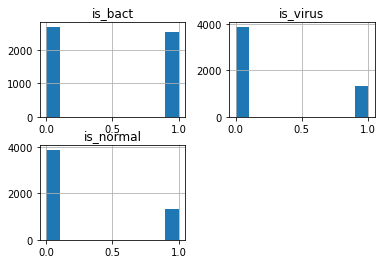

In [5]:
print(train_dataset.describe())
print(train_dataset.head())
train_dataset.hist()
plt.show()

### Notes
- looks like the data is about 1/4 normal, 1/4 viral, and 1/2 bacterial
- Next look at images to see what I might use to classify x-rays

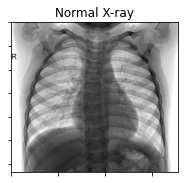

<Figure size 432x288 with 0 Axes>

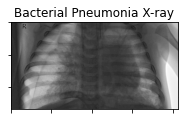

<Figure size 432x288 with 0 Axes>

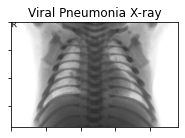

<Figure size 432x288 with 0 Axes>

In [6]:
fig = plt.figure(figsize=(3,3))
plt.imshow(file_to_array(train_dataset[train_dataset['is_normal']==1]['image_file'].iloc[0]),cmap='binary')
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("Normal X-ray")
plt.savefig("normal.png", facecolor=(1.0, 1.0,1.0))
plt.show()
plt.clf()

fig = plt.figure(figsize=(3,3))
plt.imshow(file_to_array(train_dataset[train_dataset['is_bact']==1]['image_file'].iloc[0]),cmap='binary')
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("Bacterial Pneumonia X-ray")
plt.savefig("bacteria.png", facecolor=(1.0, 1.0,1.0))
plt.show()
plt.clf()

fig = plt.figure(figsize=(3,3))
plt.imshow(file_to_array(train_dataset[train_dataset['is_virus']==1]['image_file'].iloc[0]),cmap='binary')
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("Viral Pneumonia X-ray")
plt.savefig("virus.png", facecolor=(1.0, 1.0,1.0))
plt.show()
plt.clf()

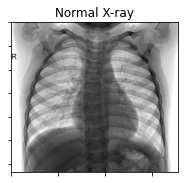

<Figure size 432x288 with 0 Axes>

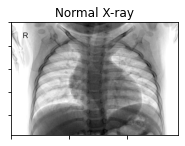

<Figure size 432x288 with 0 Axes>

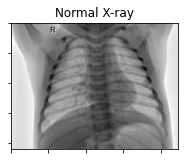

<Figure size 432x288 with 0 Axes>

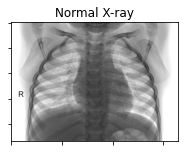

<Figure size 432x288 with 0 Axes>

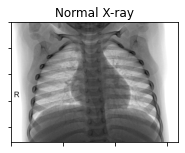

<Figure size 432x288 with 0 Axes>

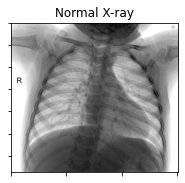

<Figure size 432x288 with 0 Axes>

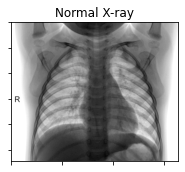

<Figure size 432x288 with 0 Axes>

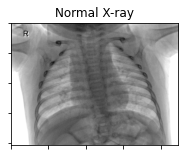

<Figure size 432x288 with 0 Axes>

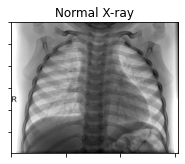

<Figure size 432x288 with 0 Axes>

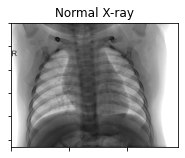

<Figure size 432x288 with 0 Axes>

In [7]:
for idx in range(10):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(file_to_array(train_dataset[train_dataset['is_normal']==1]['image_file'].iloc[idx]),cmap='binary')
    ax = plt.gca()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.title("Normal X-ray")
    plt.show()
    plt.clf()

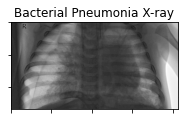

<Figure size 432x288 with 0 Axes>

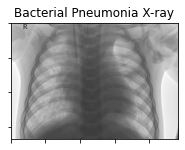

<Figure size 432x288 with 0 Axes>

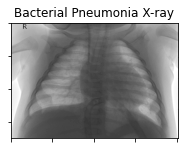

<Figure size 432x288 with 0 Axes>

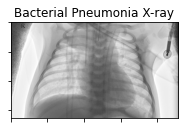

<Figure size 432x288 with 0 Axes>

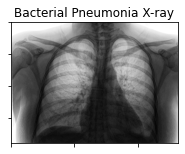

<Figure size 432x288 with 0 Axes>

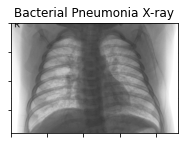

<Figure size 432x288 with 0 Axes>

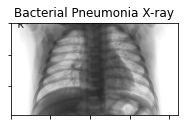

<Figure size 432x288 with 0 Axes>

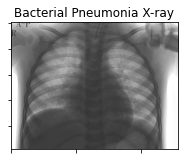

<Figure size 432x288 with 0 Axes>

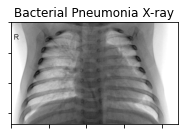

<Figure size 432x288 with 0 Axes>

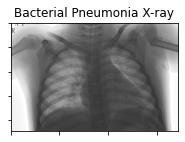

<Figure size 432x288 with 0 Axes>

In [8]:
for idx in range(10):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(file_to_array(train_dataset[train_dataset['is_bact']==1]['image_file'].iloc[idx]),cmap='binary')
    ax = plt.gca()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.title("Bacterial Pneumonia X-ray")
    plt.show()
    plt.clf()

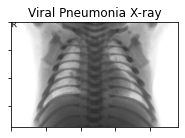

<Figure size 432x288 with 0 Axes>

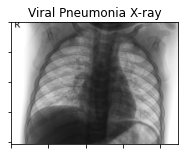

<Figure size 432x288 with 0 Axes>

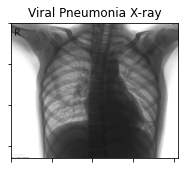

<Figure size 432x288 with 0 Axes>

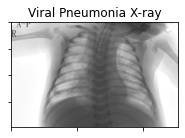

<Figure size 432x288 with 0 Axes>

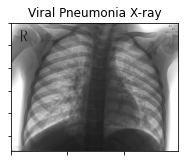

<Figure size 432x288 with 0 Axes>

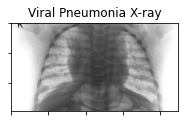

<Figure size 432x288 with 0 Axes>

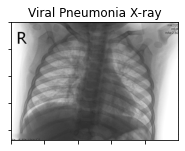

<Figure size 432x288 with 0 Axes>

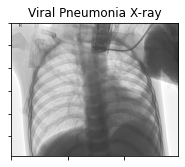

<Figure size 432x288 with 0 Axes>

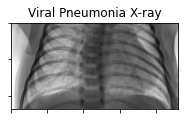

<Figure size 432x288 with 0 Axes>

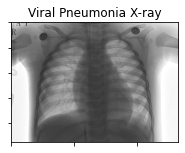

<Figure size 432x288 with 0 Axes>

In [9]:
for idx in range(10):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(file_to_array(train_dataset[train_dataset['is_virus']==1]['image_file'].iloc[idx]),cmap='binary')
    ax = plt.gca()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.title("Viral Pneumonia X-ray")
    plt.show()
    plt.clf()

### Notes
- normal x-rays appear to have more contrast of the ribs followed by bacterial and viral
- It is not clear to me the best way to look at viral vs bacterial pneumonia. might start with training on is_pneu first
- Next look at various stats of the images

In [10]:
stats_dataset = make_stats_dataset(train_dataset)
stats_dataset.describe()

is_bact     is_virus    is_normal        width       height  \
count  5216.000000  5216.000000  5216.000000  5216.000000  5216.000000   
mean      0.485046     0.257860     0.257094   968.074770  1320.610813   
std       0.499824     0.437499     0.437073   378.855691   355.298743   
min       0.000000     0.000000     0.000000   127.000000   384.000000   
25%       0.000000     0.000000     0.000000   688.000000  1056.000000   
50%       0.000000     0.000000     0.000000   888.000000  1284.000000   
75%       1.000000     1.000000     1.000000  1187.750000  1552.000000   
max       1.000000     1.000000     1.000000  2663.000000  2916.000000   

       aspect_ratio         mean          std          max          min  
count   5216.000000  5216.000000  5216.000000  5216.000000  5216.000000  
mean       0.714664   122.988132    56.908508   252.527799     0.238113  
std        0.118437    18.536296     9.532559    11.167769     2.939475  
min        0.295964    60.690319    20.415354   153.000000     0.000000  
25%        0.631545   111.890923    50.498153   255.000000     0.000000  
50%        0.708365   122.845751    57.321576   255.000000     0.000000  
75%        0.795247   134.476342    63.727310   255.000000     0.000000  
max        1.197044   221.536623    87.480423   255.000000    76.000000

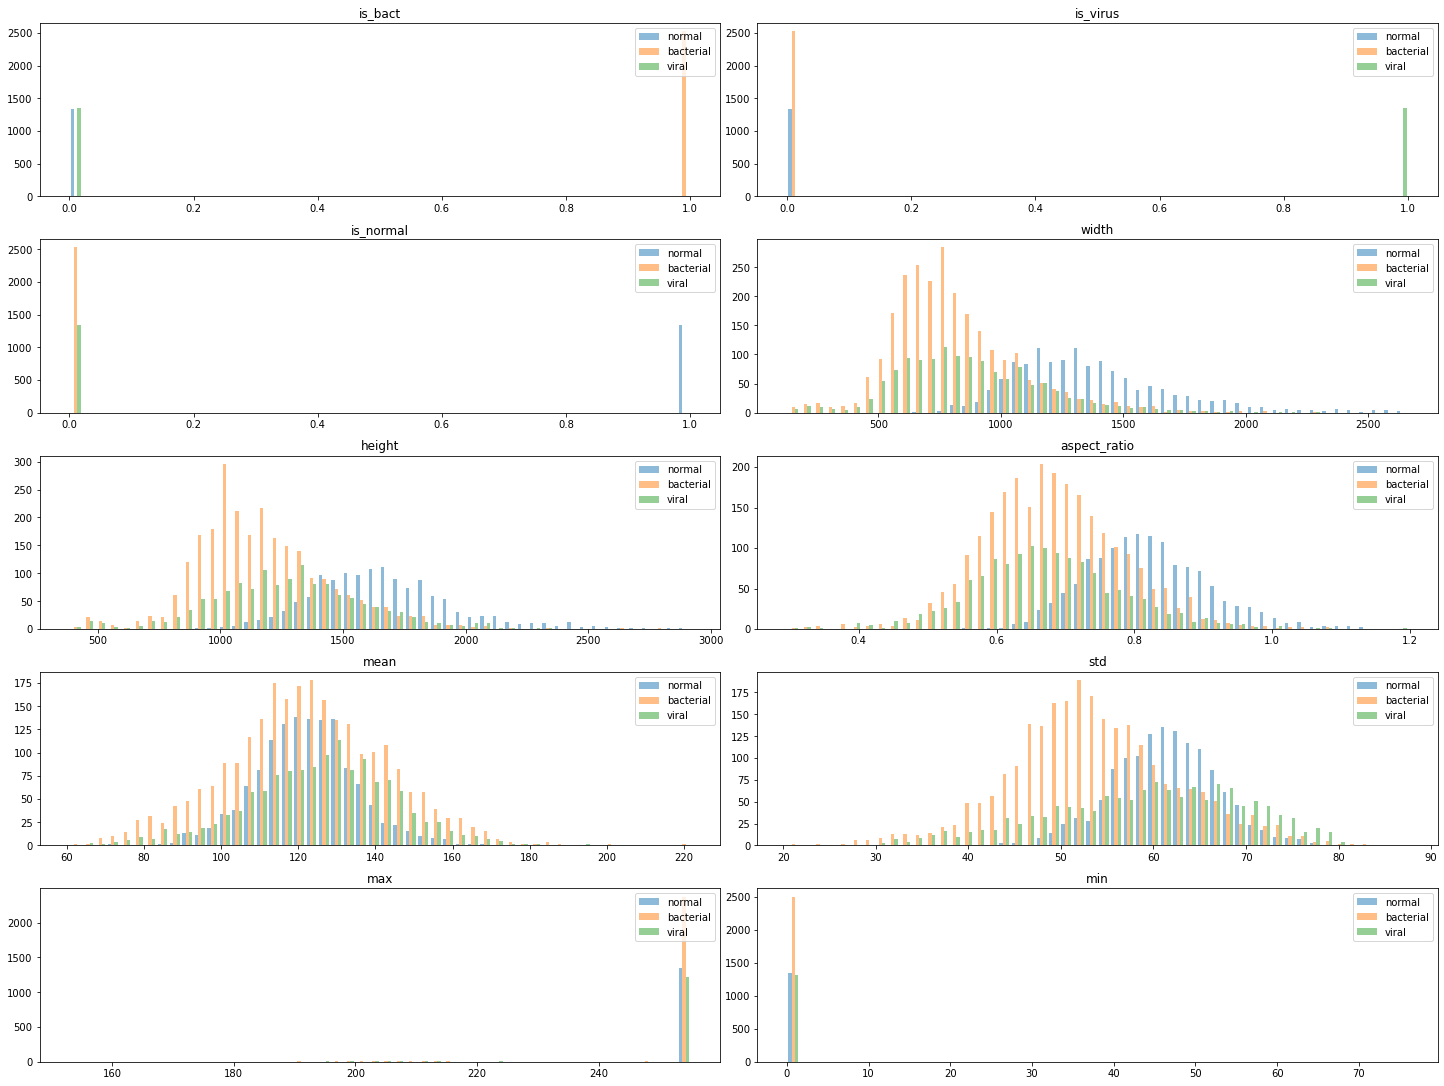

In [11]:
hist_dataset_by_type(stats_dataset,filename='image_stats.png')

### Notes
- its is concerning that the normal data is higher resolution and a different aspect ratio than the viral or bacterial data
    - center cropping to make the images square should help keep the model from learning this
    - use center crop since the images are typically centered

In [12]:
stats_center_crop_dataset = make_stats_dataset(train_dataset,center_crop_bool=True)

In [13]:
stats_center_crop_dataset.describe()

is_bact     is_virus    is_normal        width       height  \
count  5216.000000  5216.000000  5216.000000  5216.000000  5216.000000   
mean      0.485046     0.257860     0.257094   966.990222   966.990222   
std       0.499824     0.437499     0.437073   375.790388   375.790388   
min       0.000000     0.000000     0.000000   127.000000   127.000000   
25%       0.000000     0.000000     0.000000   688.000000   688.000000   
50%       0.000000     0.000000     0.000000   888.000000   888.000000   
75%       1.000000     1.000000     1.000000  1187.000000  1187.000000   
max       1.000000     1.000000     1.000000  2625.000000  2625.000000   

       aspect_ratio         mean          std          max          min  
count        5216.0  5216.000000  5216.000000  5216.000000  5216.000000  
mean            1.0   145.687456    39.581161   230.640721    20.261311  
std             0.0    19.968610     9.928428    23.752861    25.501876  
min             1.0    70.603909     8.417080   149.000000     0.000000  
25%             1.0   133.647105    33.057408   211.000000     0.000000  
50%             1.0   146.676356    39.083253   232.000000     8.000000  
75%             1.0   159.483758    45.665488   255.000000    36.000000  
max             1.0   225.399412    75.643927   255.000000   157.000000

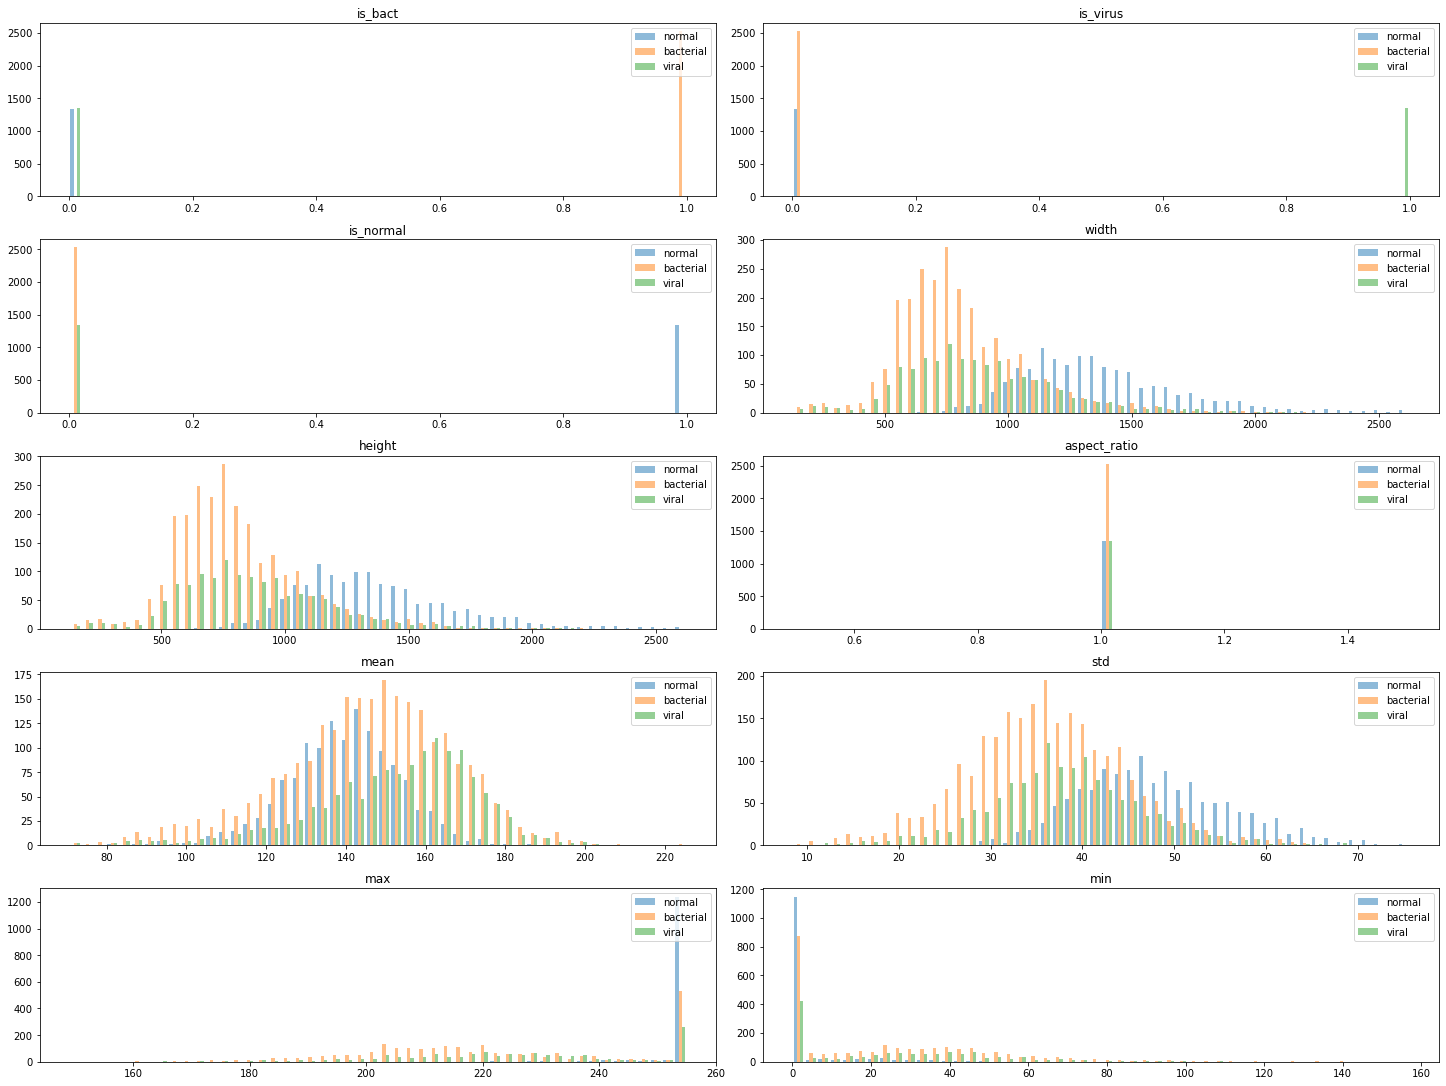

In [14]:
hist_dataset_by_type(stats_center_crop_dataset,filename='center_crop_image_stats.png')

### Notes
- center crop fixed the aspect ratio issue
- the seperation in the mean and std is expected baised on my contrast observation from before
- now make sure the images look good

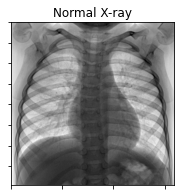

<Figure size 432x288 with 0 Axes>

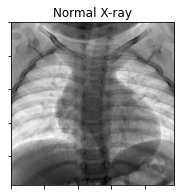

<Figure size 432x288 with 0 Axes>

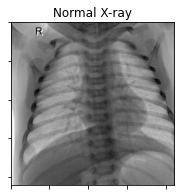

<Figure size 432x288 with 0 Axes>

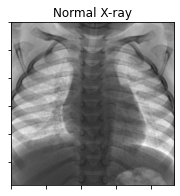

<Figure size 432x288 with 0 Axes>

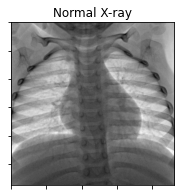

<Figure size 432x288 with 0 Axes>

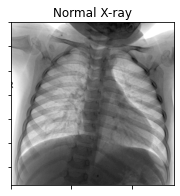

<Figure size 432x288 with 0 Axes>

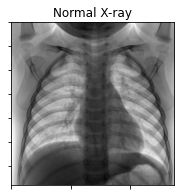

<Figure size 432x288 with 0 Axes>

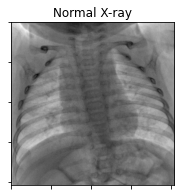

<Figure size 432x288 with 0 Axes>

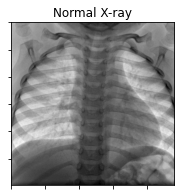

<Figure size 432x288 with 0 Axes>

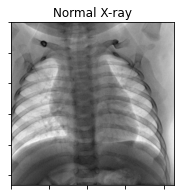

<Figure size 432x288 with 0 Axes>

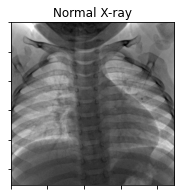

<Figure size 432x288 with 0 Axes>

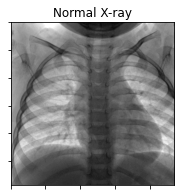

<Figure size 432x288 with 0 Axes>

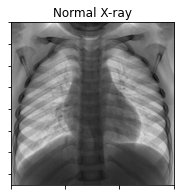

<Figure size 432x288 with 0 Axes>

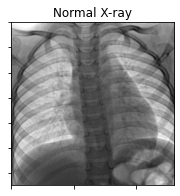

<Figure size 432x288 with 0 Axes>

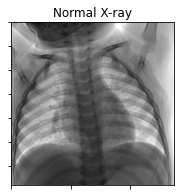

<Figure size 432x288 with 0 Axes>

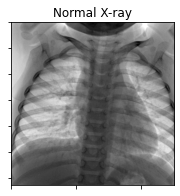

<Figure size 432x288 with 0 Axes>

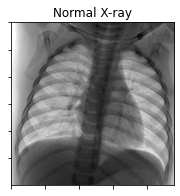

<Figure size 432x288 with 0 Axes>

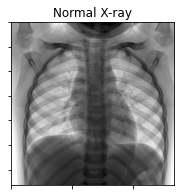

<Figure size 432x288 with 0 Axes>

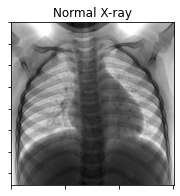

<Figure size 432x288 with 0 Axes>

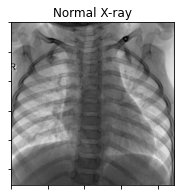

<Figure size 432x288 with 0 Axes>

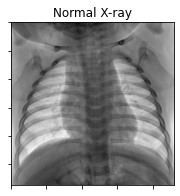

<Figure size 432x288 with 0 Axes>

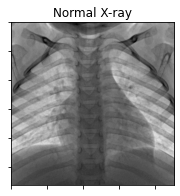

<Figure size 432x288 with 0 Axes>

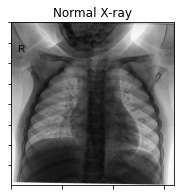

<Figure size 432x288 with 0 Axes>

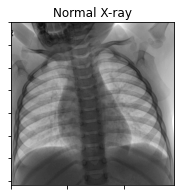

<Figure size 432x288 with 0 Axes>

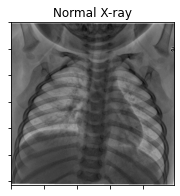

<Figure size 432x288 with 0 Axes>

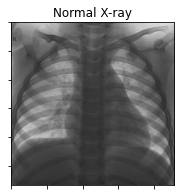

<Figure size 432x288 with 0 Axes>

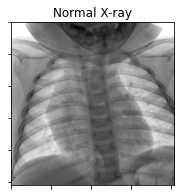

<Figure size 432x288 with 0 Axes>

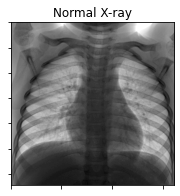

<Figure size 432x288 with 0 Axes>

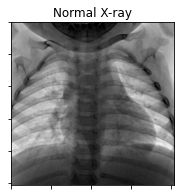

<Figure size 432x288 with 0 Axes>

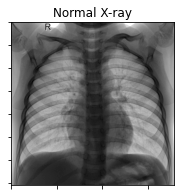

<Figure size 432x288 with 0 Axes>

In [15]:
for idx in range(30):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(center_crop(file_to_array(train_dataset[train_dataset['is_normal']==1]['image_file'].iloc[idx])),cmap='binary')
    ax = plt.gca()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.title("Normal X-ray")
    plt.show()
    plt.clf()

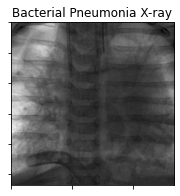

<Figure size 432x288 with 0 Axes>

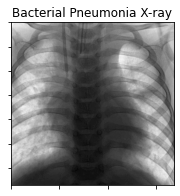

<Figure size 432x288 with 0 Axes>

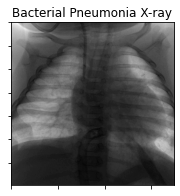

<Figure size 432x288 with 0 Axes>

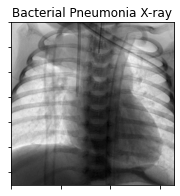

<Figure size 432x288 with 0 Axes>

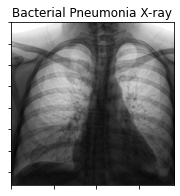

<Figure size 432x288 with 0 Axes>

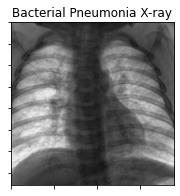

<Figure size 432x288 with 0 Axes>

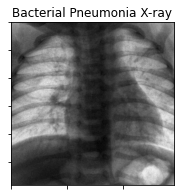

<Figure size 432x288 with 0 Axes>

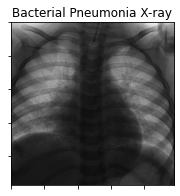

<Figure size 432x288 with 0 Axes>

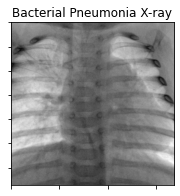

<Figure size 432x288 with 0 Axes>

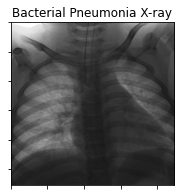

<Figure size 432x288 with 0 Axes>

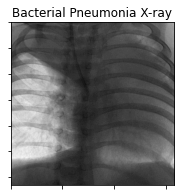

<Figure size 432x288 with 0 Axes>

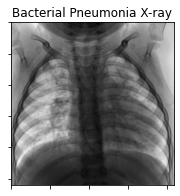

<Figure size 432x288 with 0 Axes>

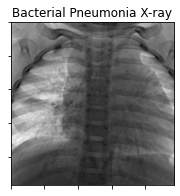

<Figure size 432x288 with 0 Axes>

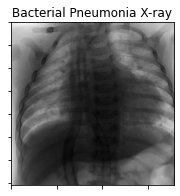

<Figure size 432x288 with 0 Axes>

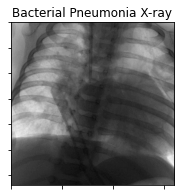

<Figure size 432x288 with 0 Axes>

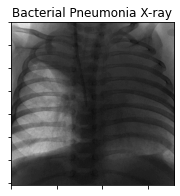

<Figure size 432x288 with 0 Axes>

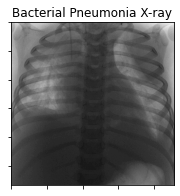

<Figure size 432x288 with 0 Axes>

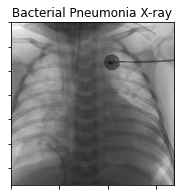

<Figure size 432x288 with 0 Axes>

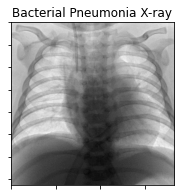

<Figure size 432x288 with 0 Axes>

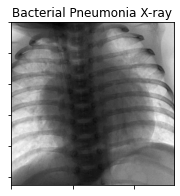

<Figure size 432x288 with 0 Axes>

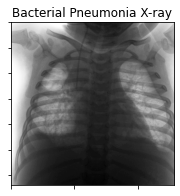

<Figure size 432x288 with 0 Axes>

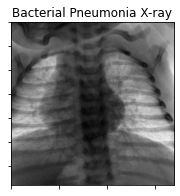

<Figure size 432x288 with 0 Axes>

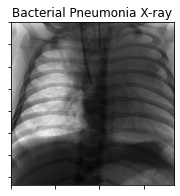

<Figure size 432x288 with 0 Axes>

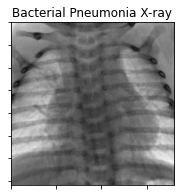

<Figure size 432x288 with 0 Axes>

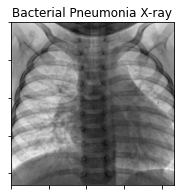

<Figure size 432x288 with 0 Axes>

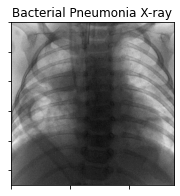

<Figure size 432x288 with 0 Axes>

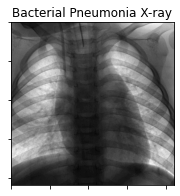

<Figure size 432x288 with 0 Axes>

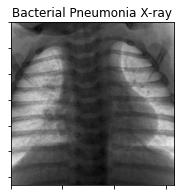

<Figure size 432x288 with 0 Axes>

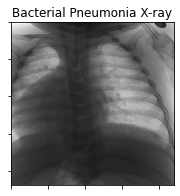

<Figure size 432x288 with 0 Axes>

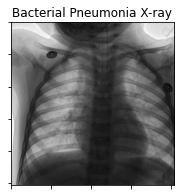

<Figure size 432x288 with 0 Axes>

In [16]:
for idx in range(30):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(center_crop(file_to_array(train_dataset[train_dataset['is_bact']==1]['image_file'].iloc[idx])),cmap='binary')
    ax = plt.gca()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.title("Bacterial Pneumonia X-ray")
    plt.show()
    plt.clf()

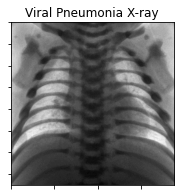

<Figure size 432x288 with 0 Axes>

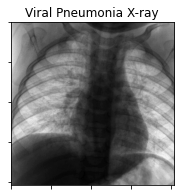

<Figure size 432x288 with 0 Axes>

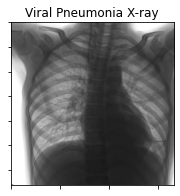

<Figure size 432x288 with 0 Axes>

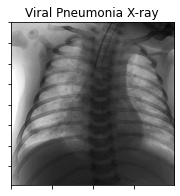

<Figure size 432x288 with 0 Axes>

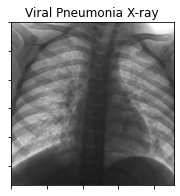

<Figure size 432x288 with 0 Axes>

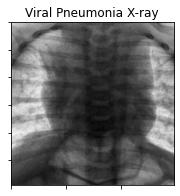

<Figure size 432x288 with 0 Axes>

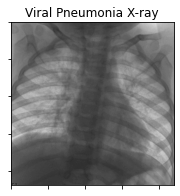

<Figure size 432x288 with 0 Axes>

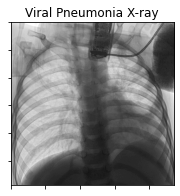

<Figure size 432x288 with 0 Axes>

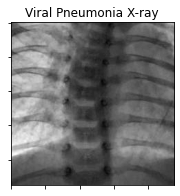

<Figure size 432x288 with 0 Axes>

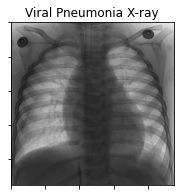

<Figure size 432x288 with 0 Axes>

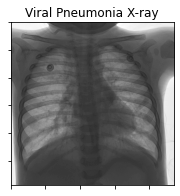

<Figure size 432x288 with 0 Axes>

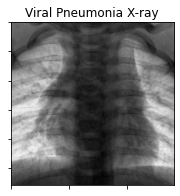

<Figure size 432x288 with 0 Axes>

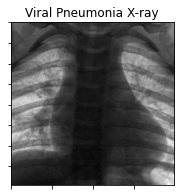

<Figure size 432x288 with 0 Axes>

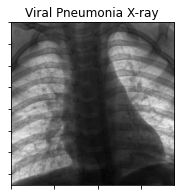

<Figure size 432x288 with 0 Axes>

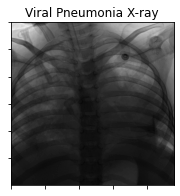

<Figure size 432x288 with 0 Axes>

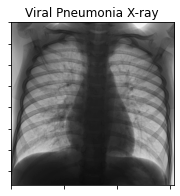

<Figure size 432x288 with 0 Axes>

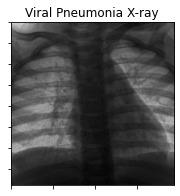

<Figure size 432x288 with 0 Axes>

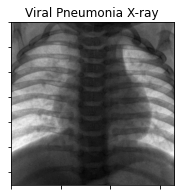

<Figure size 432x288 with 0 Axes>

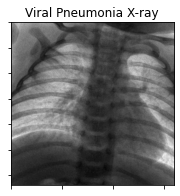

<Figure size 432x288 with 0 Axes>

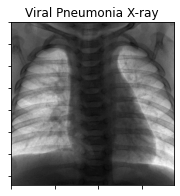

<Figure size 432x288 with 0 Axes>

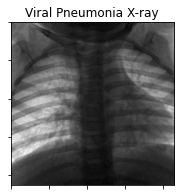

<Figure size 432x288 with 0 Axes>

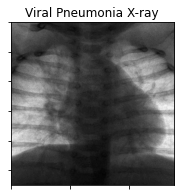

<Figure size 432x288 with 0 Axes>

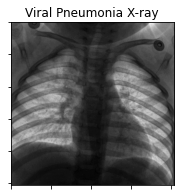

<Figure size 432x288 with 0 Axes>

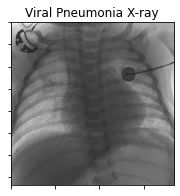

<Figure size 432x288 with 0 Axes>

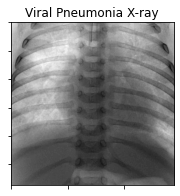

<Figure size 432x288 with 0 Axes>

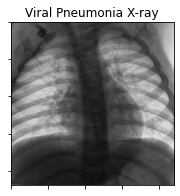

<Figure size 432x288 with 0 Axes>

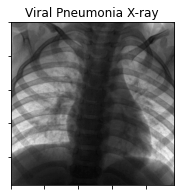

<Figure size 432x288 with 0 Axes>

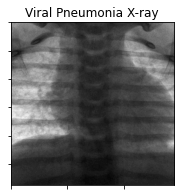

<Figure size 432x288 with 0 Axes>

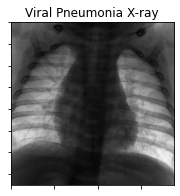

<Figure size 432x288 with 0 Axes>

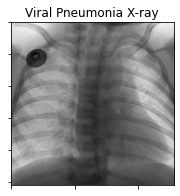

<Figure size 432x288 with 0 Axes>

In [17]:
for idx in range(30):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(center_crop(file_to_array(train_dataset[train_dataset['is_virus']==1]['image_file'].iloc[idx])),cmap='binary')
    ax = plt.gca()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.title("Viral Pneumonia X-ray")
    plt.show()
    plt.clf()

### Notes
- dataset looks pretty good now
- might be slightly more zoomed in on is_pneu = 1, but a good mix exists
- next look at an average case for each

In [18]:
print("normal_no_crop")
normal_no_crop = get_avg_image(train_dataset[train_dataset['is_normal']==1],center_crop_bool=False)
print("normal_center_crop")
normal_center_crop = get_avg_image(train_dataset[train_dataset['is_normal']==1],center_crop_bool=True)
print("bact_no_crop")
bact_no_crop = get_avg_image(train_dataset[train_dataset['is_bact']==1],center_crop_bool=False)
print("bact_center_crop")
bact_center_crop = get_avg_image(train_dataset[train_dataset['is_bact']==1],center_crop_bool=True)
print("virus_no_crop")
virus_no_crop = get_avg_image(train_dataset[train_dataset['is_virus']==1],center_crop_bool=False)
print("virus_center_crop")
virus_center_crop = get_avg_image(train_dataset[train_dataset['is_virus']==1],center_crop_bool=True)
    

normal_no_crop
normal_center_crop
bact_no_crop
bact_center_crop
virus_no_crop
virus_center_crop


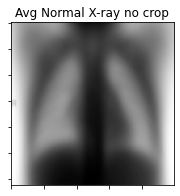

<Figure size 432x288 with 0 Axes>

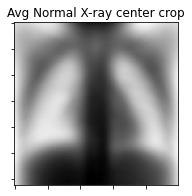

<Figure size 432x288 with 0 Axes>

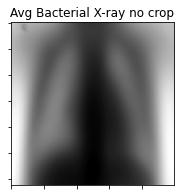

<Figure size 432x288 with 0 Axes>

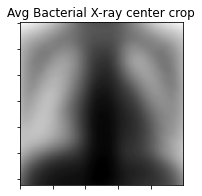

<Figure size 432x288 with 0 Axes>

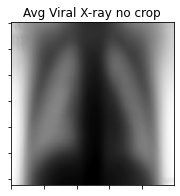

<Figure size 432x288 with 0 Axes>

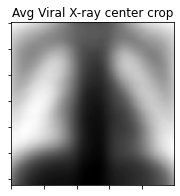

<Figure size 432x288 with 0 Axes>

In [19]:
fig = plt.figure(figsize=(3,3))
plt.imshow(normal_no_crop,cmap='binary')
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("Avg Normal X-ray no crop")
plt.savefig("avg_normal_no_crop.png", facecolor=(1.0, 1.0,1.0))
plt.show()
plt.clf()

fig = plt.figure(figsize=(3,3))
plt.imshow(normal_center_crop,cmap='binary')
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("Avg Normal X-ray center crop")
plt.savefig("avg_normal_center_crop.png", facecolor=(1.0, 1.0,1.0))
plt.show()
plt.clf()

fig = plt.figure(figsize=(3,3))
plt.imshow(bact_no_crop,cmap='binary')
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("Avg Bacterial X-ray no crop")
plt.savefig("avg_bact_no_crop.png", facecolor=(1.0, 1.0,1.0))
plt.show()
plt.clf()

fig = plt.figure(figsize=(3,3))
plt.imshow(bact_center_crop,cmap='binary')
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("Avg Bacterial X-ray center crop")
plt.savefig("avg_bact_center_crop.png", facecolor=(1.0, 1.0,1.0))
plt.show()
plt.clf()

fig = plt.figure(figsize=(3,3))
plt.imshow(virus_no_crop,cmap='binary')
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("Avg Viral X-ray no crop")
plt.savefig("avg_virus_no_crop.png", facecolor=(1.0, 1.0,1.0))
plt.show()
plt.clf()

fig = plt.figure(figsize=(3,3))
plt.imshow(virus_center_crop,cmap='binary')
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("Avg Viral X-ray center crop")
plt.savefig("avg_virus_center_crop.png", facecolor=(1.0, 1.0,1.0))
plt.show()
plt.clf()

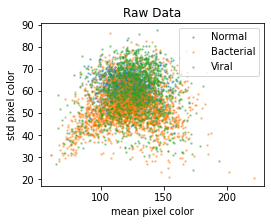

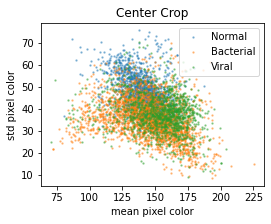

In [20]:
alpha = 0.4
s=2
fig = plt.figure(figsize=(4,3))
plt.scatter(stats_dataset[stats_dataset['is_normal']==1]['mean'], stats_dataset[stats_dataset['is_normal']==1]['std'], alpha=alpha, s=s, label='Normal')
plt.scatter(stats_dataset[stats_dataset['is_bact']==1]['mean'], stats_dataset[stats_dataset['is_bact']==1]['std'], alpha=alpha, s=s, label='Bacterial')
plt.scatter(stats_dataset[stats_dataset['is_virus']==1]['mean'], stats_dataset[stats_dataset['is_virus']==1]['std'], alpha=alpha, s=s, label='Viral')
plt.legend()
plt.xlabel("mean pixel color")
plt.ylabel("std pixel color")
plt.title("Raw Data")
plt.savefig("mean_vs_std_no_crop.png", facecolor=(1.0, 1.0,1.0))
plt.show()

fig = plt.figure(figsize=(4,3))
plt.scatter(stats_center_crop_dataset[stats_center_crop_dataset['is_normal']==1]['mean'], stats_center_crop_dataset[stats_center_crop_dataset['is_normal']==1]['std'], alpha=alpha, s=s, label='Normal')
plt.scatter(stats_center_crop_dataset[stats_center_crop_dataset['is_bact']==1]['mean'], stats_center_crop_dataset[stats_center_crop_dataset['is_bact']==1]['std'], alpha=alpha, s=s, label='Bacterial')
plt.scatter(stats_center_crop_dataset[stats_center_crop_dataset['is_virus']==1]['mean'], stats_center_crop_dataset[stats_center_crop_dataset['is_virus']==1]['std'], alpha=alpha, s=s, label='Viral')
plt.legend()
plt.xlabel("mean pixel color")
plt.ylabel("std pixel color")
plt.title("Center Crop")
plt.savefig("mean_vs_std_center_crop.png", facecolor=(1.0, 1.0,1.0))
plt.show()

# Data Pipeline

In [21]:
class ReadCropResNorm(BaseEstimator, TransformerMixin):
    def __init__(self, crop=True, resolution=[125,125], norm=255, add_channels=False):
        self.crop = crop
        self.resolution = resolution
        self.norm = norm
        self.add_channels = add_channels
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        data = []
        for idx, file in enumerate(X):
            if idx % 1000 == 0:
                print(idx)
            cur_data = file_to_array(file)
            if self.crop:
                cur_data = center_crop(cur_data)
            cur_data = resize_image(cur_data, shape=self.resolution)
            cur_data = cur_data.astype(float)
            cur_data /= self.norm
            data.append(cur_data)
        data = np.array(data)
        if self.add_channels:
            data = data.reshape([data.shape[0],data.shape[1],data.shape[2],1])
        return data
    
def linear_dnn_model(n_hidden=2, 
                     learning_rate=1e-3, 
                     n_nodes=100, 
                     input_shape=[14], 
                     activation='relu', 
                     output_shape=3,
                     momentum=0.9,
                     nesterov=True,
                    use_adam=True,
                    beta_1 = 0.9,
                    beta_2 = 0.999):
    model = keras.models.Sequential()
    model.add(Flatten(input_shape=input_shape))
    for n in range(n_hidden):
        model.add(Dense(n_nodes, activation=activation))
    if output_shape == 1:
        model.add(Dense(output_shape, activation='sigmoid'))
    else:
        model.add(Dense(output_shape, activation='softmax'))
    if use_adam:
        optimizer = keras.optimizers.Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2)
    else:
        optimizer = keras.optimizers.SGD(lr=learning_rate,momentum=momentum, nesterov=nesterov)
    if output_shape == 1:
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def linear_cnn_model(n_hidden=2, 
                     learning_rate=1e-3, 
                     kernel_size=4, 
                     n_conv=8, 
                     n_nodes=100, 
                     input_shape=[128,128,1], 
                     activation='relu', 
                     output_shape=3,
                     momentum=0.9,
                     nesterov=True,
                    use_adam=True,
                    beta_1 = 0.9,
                    beta_2 = 0.999):
    model = keras.models.Sequential()
    model.add(Conv2D(n_conv, kernel_size=[kernel_size,kernel_size], activation=activation,data_format="channels_last", input_shape=input_shape))
    for n in range(n_hidden-1):
        model.add(Conv2D(n_conv*(2*(n+1)), kernel_size=[kernel_size,kernel_size], activation=activation))
    model.add(Flatten())
    if output_shape == 1:
        model.add(Dense(output_shape, activation='sigmoid'))
    else:
        model.add(Dense(output_shape, activation='softmax'))
    if use_adam:
        optimizer = keras.optimizers.Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2)
    else:
        optimizer = keras.optimizers.SGD(lr=learning_rate,momentum=momentum, nesterov=nesterov)
    if output_shape == 1:
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def plot_history(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
#     plt.gca().set_ylim(0,1)
    plt.show()

In [22]:
train_dataset_v, valid_dataset = train_test_split(train_dataset, random_state=42, test_size=0.1)
y_train_v_3 = train_dataset_v[['is_bact', 'is_virus', 'is_normal']]
y_train_v_1 = train_dataset_v['is_normal']
y_valid_3 = valid_dataset[['is_bact', 'is_virus', 'is_normal']]
y_valid_1 = valid_dataset['is_normal']

print(train_dataset_v.shape, valid_dataset.shape)
print(y_valid_3[:30])

(4694, 4) (522, 4)
      is_bact  is_virus  is_normal
1897        1         0          0
877         0         0          1
4503        0         1          0
4725        1         0          0
1595        0         1          0
4709        0         1          0
893         1         0          0
1292        0         0          1
1168        0         1          0
1144        1         0          0
4860        1         0          0
553         0         0          1
4367        0         0          1
3558        1         0          0
1736        1         0          0
4163        1         0          0
1321        1         0          0
2732        1         0          0
23          1         0          0
3501        1         0          0
5096        0         1          0
2229        0         1          0
530         0         1          0
2456        1         0          0
4349        0         0          1
1869        0         1          0
3593        0         1          0
6

### dnn normal only

In [23]:
# dnn_model = Pipeline([('rcrn', ReadCropResNorm(crop=True, resolution=[125,125], norm=255)), # reads image, crops, reduces resolution, and normalizes
#                   ('DNN', KerasClassifier(build_fn=linear_dnn_model,input_shape=[125,125],output_shape=1,nb_epoch=50)), # DNN
#                   ])
x_data = ReadCropResNorm(crop=True, resolution=[125,125], norm=255).transform(train_dataset_v['image_file'])
x_val_data = ReadCropResNorm(crop=True, resolution=[125,125], norm=255).transform(valid_dataset['image_file'])

0
1000
2000
3000
4000
0


In [24]:
dnn_model = linear_dnn_model(input_shape=[125,125],output_shape=1)

history = dnn_model.fit(x_data, y_train_v_1, epochs=200, validation_data=(x_val_data, y_valid_1))

Epoch 1/200
147/147 [==============================] - 2s 12ms/step - loss: 0.7325 - accuracy: 0.7719 - val_loss: 0.2275 - val_accuracy: 0.8870
Epoch 2/200
147/147 [==============================] - 1s 8ms/step - loss: 0.1883 - accuracy: 0.9218 - val_loss: 0.1551 - val_accuracy: 0.9425
Epoch 3/200
147/147 [==============================] - 1s 8ms/step - loss: 0.1477 - accuracy: 0.9392 - val_loss: 0.1709 - val_accuracy: 0.9387
Epoch 4/200
147/147 [==============================] - 1s 8ms/step - loss: 0.1850 - accuracy: 0.9240 - val_loss: 0.1296 - val_accuracy: 0.9521
Epoch 5/200
147/147 [==============================] - 1s 7ms/step - loss: 0.1596 - accuracy: 0.9401 - val_loss: 0.1286 - val_accuracy: 0.9559
Epoch 6/200
147/147 [==============================] - 1s 7ms/step - loss: 0.1578 - accuracy: 0.9368 - val_loss: 0.1368 - val_accuracy: 0.9406
Epoch 7/200
147/147 [==============================] - 1s 7ms/step - loss: 0.1939 - accuracy: 0.9218 - val_loss: 0.1225 - val_accuracy: 0.952

Epoch 58/200
147/147 [==============================] - 1s 7ms/step - loss: 0.0953 - accuracy: 0.9644 - val_loss: 0.1017 - val_accuracy: 0.9521
Epoch 59/200
147/147 [==============================] - 1s 8ms/step - loss: 0.0746 - accuracy: 0.9695 - val_loss: 0.1024 - val_accuracy: 0.9521
Epoch 60/200
147/147 [==============================] - 1s 8ms/step - loss: 0.1042 - accuracy: 0.9672 - val_loss: 0.1000 - val_accuracy: 0.9579
Epoch 61/200
147/147 [==============================] - 1s 8ms/step - loss: 0.0784 - accuracy: 0.9676 - val_loss: 0.0997 - val_accuracy: 0.9579
Epoch 62/200
147/147 [==============================] - 1s 8ms/step - loss: 0.0764 - accuracy: 0.9721 - val_loss: 0.1086 - val_accuracy: 0.9521
Epoch 63/200
147/147 [==============================] - 1s 7ms/step - loss: 0.0700 - accuracy: 0.9724 - val_loss: 0.1057 - val_accuracy: 0.9540
Epoch 64/200
147/147 [==============================] - 1s 7ms/step - loss: 0.0823 - accuracy: 0.9703 - val_loss: 0.1061 - val_accuracy:

Epoch 115/200
147/147 [==============================] - 1s 8ms/step - loss: 0.0638 - accuracy: 0.9795 - val_loss: 0.1164 - val_accuracy: 0.9579
Epoch 116/200
147/147 [==============================] - 1s 7ms/step - loss: 0.0623 - accuracy: 0.9782 - val_loss: 0.1313 - val_accuracy: 0.9559
Epoch 117/200
147/147 [==============================] - 1s 7ms/step - loss: 0.0832 - accuracy: 0.9678 - val_loss: 0.2237 - val_accuracy: 0.9215
Epoch 118/200
147/147 [==============================] - 1s 8ms/step - loss: 0.0987 - accuracy: 0.9650 - val_loss: 0.2438 - val_accuracy: 0.9157
Epoch 119/200
147/147 [==============================] - 1s 8ms/step - loss: 0.0584 - accuracy: 0.9788 - val_loss: 0.1557 - val_accuracy: 0.9444
Epoch 120/200
147/147 [==============================] - 1s 7ms/step - loss: 0.0735 - accuracy: 0.9752 - val_loss: 0.1114 - val_accuracy: 0.9579
Epoch 121/200
147/147 [==============================] - 1s 7ms/step - loss: 0.0798 - accuracy: 0.9729 - val_loss: 0.1142 - val_ac

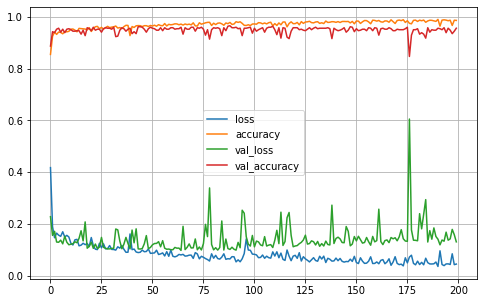

In [25]:
plot_history(history)

### DNN all 3

In [26]:
# dnn_model = Pipeline([('rcrn', ReadCropResNorm(crop=True, resolution=[125,125], norm=255)), # reads image, crops, reduces resolution, and normalizes
#                   ('DNN', KerasClassifier(build_fn=linear_dnn_model,input_shape=[125,125],output_shape=3)), # DNN
#                   ])
dnn_model_3 = linear_dnn_model(input_shape=[125,125],output_shape=3)
history_dnn_3 = dnn_model_3.fit(x_data, y_train_v_3, epochs=200, validation_data=(x_val_data, y_valid_3))

Epoch 1/200
147/147 [==============================] - 2s 9ms/step - loss: 1.3281 - accuracy: 0.5430 - val_loss: 0.7820 - val_accuracy: 0.5402
Epoch 2/200
147/147 [==============================] - 1s 8ms/step - loss: 0.6929 - accuracy: 0.6852 - val_loss: 0.6333 - val_accuracy: 0.7069
Epoch 3/200
147/147 [==============================] - 1s 8ms/step - loss: 0.6534 - accuracy: 0.6991 - val_loss: 0.6577 - val_accuracy: 0.6973
Epoch 4/200
147/147 [==============================] - 1s 8ms/step - loss: 0.6471 - accuracy: 0.7056 - val_loss: 0.8013 - val_accuracy: 0.6398
Epoch 5/200
147/147 [==============================] - 1s 8ms/step - loss: 0.6108 - accuracy: 0.7253 - val_loss: 0.6346 - val_accuracy: 0.7184
Epoch 6/200
147/147 [==============================] - 1s 8ms/step - loss: 0.5893 - accuracy: 0.7274 - val_loss: 0.5642 - val_accuracy: 0.7471
Epoch 7/200
147/147 [==============================] - 1s 7ms/step - loss: 0.5919 - accuracy: 0.7236 - val_loss: 0.8265 - val_accuracy: 0.6341

Epoch 58/200
147/147 [==============================] - 1s 7ms/step - loss: 0.5264 - accuracy: 0.7722 - val_loss: 0.5372 - val_accuracy: 0.7452
Epoch 59/200
147/147 [==============================] - 1s 7ms/step - loss: 0.4754 - accuracy: 0.7933 - val_loss: 0.5513 - val_accuracy: 0.7375
Epoch 60/200
147/147 [==============================] - 1s 7ms/step - loss: 0.4821 - accuracy: 0.7945 - val_loss: 0.5251 - val_accuracy: 0.7567
Epoch 61/200
147/147 [==============================] - 1s 8ms/step - loss: 0.4848 - accuracy: 0.7776 - val_loss: 0.5262 - val_accuracy: 0.7452
Epoch 62/200
147/147 [==============================] - 1s 7ms/step - loss: 0.4772 - accuracy: 0.7884 - val_loss: 0.5911 - val_accuracy: 0.7356
Epoch 63/200
147/147 [==============================] - 1s 7ms/step - loss: 0.5148 - accuracy: 0.7660 - val_loss: 0.5774 - val_accuracy: 0.7011
Epoch 64/200
147/147 [==============================] - 1s 7ms/step - loss: 0.5475 - accuracy: 0.7296 - val_loss: 0.5934 - val_accuracy:

Epoch 115/200
147/147 [==============================] - 1s 8ms/step - loss: 0.5470 - accuracy: 0.7309 - val_loss: 0.5736 - val_accuracy: 0.7031
Epoch 116/200
147/147 [==============================] - 1s 7ms/step - loss: 0.5522 - accuracy: 0.7303 - val_loss: 0.5817 - val_accuracy: 0.7050
Epoch 117/200
147/147 [==============================] - 1s 8ms/step - loss: 0.5886 - accuracy: 0.7157 - val_loss: 0.6142 - val_accuracy: 0.6897
Epoch 118/200
147/147 [==============================] - 1s 8ms/step - loss: 0.5905 - accuracy: 0.7148 - val_loss: 0.5759 - val_accuracy: 0.7011
Epoch 119/200
147/147 [==============================] - 1s 8ms/step - loss: 0.5744 - accuracy: 0.7095 - val_loss: 0.5719 - val_accuracy: 0.7088
Epoch 120/200
147/147 [==============================] - 1s 8ms/step - loss: 0.5483 - accuracy: 0.7278 - val_loss: 0.5693 - val_accuracy: 0.7107
Epoch 121/200
147/147 [==============================] - 1s 8ms/step - loss: 0.5456 - accuracy: 0.7357 - val_loss: 0.5723 - val_ac

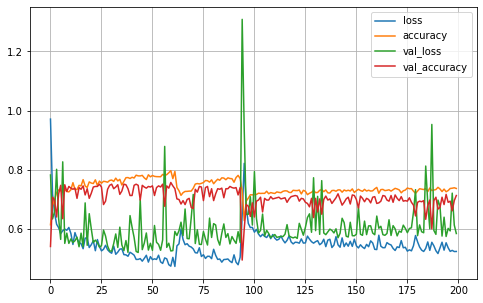

In [27]:
plot_history(history_dnn_3)

In [28]:
# cnn_model = Pipeline([('rcrn', ReadCropResNorm(crop=True, resolution=[128,128], norm=255, add_channels=True)), # reads image, crops, reduces resolution, and normalizes
#                   ('CNN', KerasClassifier(build_fn=linear_cnn_model,input_iishape=[128,128,1],output_shape=1)), # CNN
#                   ])

x_data_cnn = ReadCropResNorm(crop=True, resolution=[128,128], norm=255, add_channels=True).transform(train_dataset_v['image_file'])
x_val_data_cnn =ReadCropResNorm(crop=True, resolution=[128,128], norm=255, add_channels=True).transform(valid_dataset['image_file'])

0
1000
2000
3000
4000
0


### CNN normal only

In [29]:
cnn_model = linear_cnn_model(input_shape=[128,128,1],output_shape=1)
history_cnn_1 = cnn_model.fit(x_data_cnn, y_train_v_1, epochs=200, validation_data=(x_val_data_cnn, y_valid_1))

Epoch 1/200
147/147 [==============================] - 25s 168ms/step - loss: 0.3553 - accuracy: 0.8394 - val_loss: 0.1420 - val_accuracy: 0.9406
Epoch 2/200
147/147 [==============================] - 25s 169ms/step - loss: 0.1012 - accuracy: 0.9637 - val_loss: 0.1068 - val_accuracy: 0.9636
Epoch 3/200
147/147 [==============================] - 25s 168ms/step - loss: 0.0811 - accuracy: 0.9698 - val_loss: 0.1085 - val_accuracy: 0.9540
Epoch 4/200
147/147 [==============================] - 25s 173ms/step - loss: 0.0742 - accuracy: 0.9716 - val_loss: 0.1113 - val_accuracy: 0.9579
Epoch 5/200
147/147 [==============================] - 28s 191ms/step - loss: 0.0412 - accuracy: 0.9882 - val_loss: 0.1298 - val_accuracy: 0.9540
Epoch 6/200
147/147 [==============================] - 30s 207ms/step - loss: 0.0323 - accuracy: 0.9901 - val_loss: 0.1067 - val_accuracy: 0.9579
Epoch 7/200
147/147 [==============================] - 32s 217ms/step - loss: 0.0230 - accuracy: 0.9921 - val_loss: 0.1169 -

Epoch 56/200
147/147 [==============================] - 32s 216ms/step - loss: 5.8859e-06 - accuracy: 1.0000 - val_loss: 0.2241 - val_accuracy: 0.9598
Epoch 57/200
147/147 [==============================] - 32s 220ms/step - loss: 5.9547e-06 - accuracy: 1.0000 - val_loss: 0.2360 - val_accuracy: 0.9617
Epoch 58/200
147/147 [==============================] - 34s 230ms/step - loss: 5.8055e-06 - accuracy: 1.0000 - val_loss: 0.2324 - val_accuracy: 0.9617
Epoch 59/200
147/147 [==============================] - 35s 235ms/step - loss: 4.9875e-06 - accuracy: 1.0000 - val_loss: 0.2377 - val_accuracy: 0.9617
Epoch 60/200
147/147 [==============================] - 37s 252ms/step - loss: 4.7706e-06 - accuracy: 1.0000 - val_loss: 0.2324 - val_accuracy: 0.9598
Epoch 61/200
147/147 [==============================] - 38s 258ms/step - loss: 4.2413e-06 - accuracy: 1.0000 - val_loss: 0.2294 - val_accuracy: 0.9598
Epoch 62/200
147/147 [==============================] - 38s 258ms/step - loss: 4.2086e-06 - ac

147/147 [==============================] - 29s 197ms/step - loss: 1.1510e-04 - accuracy: 1.0000 - val_loss: 0.3062 - val_accuracy: 0.9425
Epoch 165/200
147/147 [==============================] - 29s 199ms/step - loss: 1.0189e-04 - accuracy: 1.0000 - val_loss: 0.3107 - val_accuracy: 0.9425
Epoch 166/200
147/147 [==============================] - 30s 202ms/step - loss: 9.3774e-05 - accuracy: 1.0000 - val_loss: 0.3098 - val_accuracy: 0.9425
Epoch 167/200
147/147 [==============================] - 34s 230ms/step - loss: 7.3304e-05 - accuracy: 1.0000 - val_loss: 0.3231 - val_accuracy: 0.9444
Epoch 168/200
147/147 [==============================] - 30s 203ms/step - loss: 9.5147e-05 - accuracy: 1.0000 - val_loss: 0.3112 - val_accuracy: 0.9444
Epoch 169/200
147/147 [==============================] - 30s 204ms/step - loss: 7.2971e-05 - accuracy: 1.0000 - val_loss: 0.3151 - val_accuracy: 0.9444
Epoch 170/200
147/147 [==============================] - 31s 208ms/step - loss: 6.4120e-05 - accuracy:

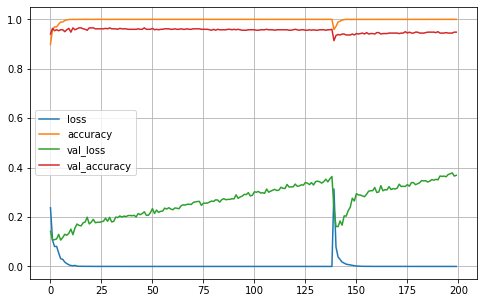

In [30]:
plot_history(history_cnn_1)

### CNN all 3

In [31]:
# cnn_model = Pipeline([('rcrn', ReadCropResNorm(crop=True, resolution=[125,125], norm=255, add_channels=True)), # reads image, crops, reduces resolution, and normalizes
#                   ('CNN', KerasClassifier(build_fn=linear_cnn_model,input_shape=[125,125,1],output_shape=3)), # CNN
#                   ])
cnn_model_3 = linear_cnn_model(input_shape=[128,128,1],output_shape=3)
history_cnn_3 = cnn_model_3.fit(x_data_cnn, y_train_v_3, epochs=200, validation_data=(x_val_data_cnn, y_valid_3))

Epoch 1/200
147/147 [==============================] - 28s 186ms/step - loss: 2.7877 - accuracy: 0.5219 - val_loss: 0.6006 - val_accuracy: 0.7471
Epoch 2/200
147/147 [==============================] - 28s 187ms/step - loss: 0.6064 - accuracy: 0.7351 - val_loss: 0.5769 - val_accuracy: 0.7452
Epoch 3/200
147/147 [==============================] - 28s 188ms/step - loss: 0.5380 - accuracy: 0.7592 - val_loss: 0.5928 - val_accuracy: 0.7395
Epoch 4/200
147/147 [==============================] - 27s 184ms/step - loss: 0.5078 - accuracy: 0.7850 - val_loss: 0.6097 - val_accuracy: 0.6858
Epoch 5/200
147/147 [==============================] - 27s 185ms/step - loss: 0.4890 - accuracy: 0.7914 - val_loss: 0.5860 - val_accuracy: 0.7203
Epoch 6/200
147/147 [==============================] - 27s 183ms/step - loss: 0.4392 - accuracy: 0.8128 - val_loss: 0.5457 - val_accuracy: 0.7299
Epoch 7/200
147/147 [==============================] - 27s 186ms/step - loss: 0.3765 - accuracy: 0.8344 - val_loss: 0.5870 -

147/147 [==============================] - 29s 195ms/step - loss: 7.6065e-07 - accuracy: 1.0000 - val_loss: 3.4838 - val_accuracy: 0.7222
Epoch 111/200
147/147 [==============================] - 29s 200ms/step - loss: 7.4204e-07 - accuracy: 1.0000 - val_loss: 3.4905 - val_accuracy: 0.7280
Epoch 112/200
147/147 [==============================] - 27s 185ms/step - loss: 6.3341e-07 - accuracy: 1.0000 - val_loss: 3.5130 - val_accuracy: 0.7299
Epoch 113/200
147/147 [==============================] - 27s 186ms/step - loss: 5.8302e-07 - accuracy: 1.0000 - val_loss: 3.5293 - val_accuracy: 0.7280
Epoch 114/200
147/147 [==============================] - 29s 195ms/step - loss: 5.2584e-07 - accuracy: 1.0000 - val_loss: 3.5450 - val_accuracy: 0.7222
Epoch 115/200
147/147 [==============================] - 30s 205ms/step - loss: 4.9551e-07 - accuracy: 1.0000 - val_loss: 3.5830 - val_accuracy: 0.7261
Epoch 116/200
147/147 [==============================] - 30s 202ms/step - loss: 4.4664e-07 - accuracy:

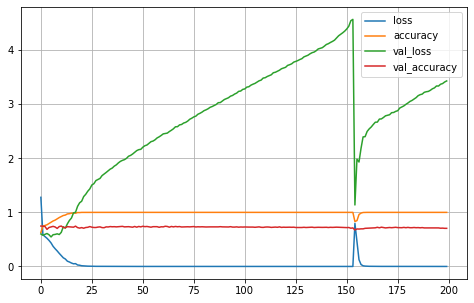

In [32]:
plot_history(history_cnn_3)